In [1]:
#Loading in Pretrained Model
import sys
import os
sys.version
import keras
from keras import callbacks
from keras import backend as K
from keras.applications.resnet50 import ResNet50
from model_util import create_submission, creade_model_2hidden

res_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


# Loading the VGG19 Pre-Trained Model

# Model V3

## Add Second Hidden Layer and Re Train the last 2 layers of Resnet

### Same architecture as VGG16 & VGG19 models

In [3]:
# Set last 2 layers of Resnet as trainable

res_base.trainable = True

set_trainable = False
for layer in res_base.layers:
    if layer.name == 'res5b_branch2a' :
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
print(len(res_base.trainable_weights))

24


In [4]:
model_rn,callbacks = creade_model_2hidden(res_base)
model_rn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total para

In [5]:
from keras.utils import multi_gpu_model
from keras import optimizers
parallel_model = multi_gpu_model(model_rn, gpus=2)
parallel_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

## Splitting Data into Train and Validate Sets (80% Train % 20% Validation)

In [7]:
from keras.preprocessing.image import ImageDataGenerator


base_dir = '/home/jupyter/Data'
train_dir = os.path.join(base_dir, 'train')

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
    validation_split=0.2
    )



train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical',
        subset="training",
        shuffle = True
        )

validation_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical',
        subset="validation",
        shuffle = True
        )

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


# Run Model Resnet

In [10]:
history_resnet = parallel_model.fit_generator(
      train_generator,
      steps_per_epoch=100,#len(train_generator)
      epochs=100,
      validation_data=validation_generator,
      validation_steps=100,#len(validation_generator)
      callbacks=callbacks,
      #use_multiprocessing = True,
      workers = 4,
      shuffle = True,
      verbose=1)

print("Finished")

Epoch 1/100
100/100 [==============================] - 22s 223ms/step - loss: 2.3015 - acc: 0.1310 - val_loss: 2.3208 - val_acc: 0.0905
1e-05
Epoch 2/100
100/100 [==============================] - 22s 218ms/step - loss: 2.2924 - acc: 0.1345 - val_loss: 2.3155 - val_acc: 0.0848
1e-05
Epoch 3/100
100/100 [==============================] - 22s 219ms/step - loss: 2.3022 - acc: 0.1275 - val_loss: 2.3212 - val_acc: 0.0880
1e-05
Epoch 4/100
100/100 [==============================] - 22s 219ms/step - loss: 2.3059 - acc: 0.1313 - val_loss: 2.3311 - val_acc: 0.0795
1e-05
Epoch 5/100
100/100 [==============================] - 22s 220ms/step - loss: 2.2961 - acc: 0.1265 - val_loss: 2.3281 - val_acc: 0.0838
1e-05
Epoch 6/100
100/100 [==============================] - 22s 220ms/step - loss: 2.2923 - acc: 0.1310 - val_loss: 2.3191 - val_acc: 0.0990
1e-05
Epoch 7/100
100/100 [==============================] - 22s 220ms/step - loss: 2.2875 - acc: 0.1455 - val_loss: 2.3125 - val_acc: 0.1010
1e-05
Epoch 

# Resnet
# Plot Training and Validation Accuracy of 100 Epoch model 

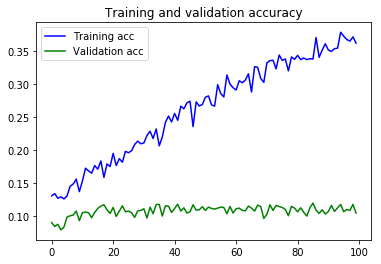

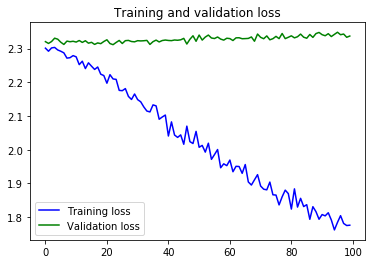

In [12]:
import matplotlib.pyplot as plt
acc = history_resnet.history['acc']
val_acc = history_resnet.history['val_acc']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Save Model

In [13]:
model_json = model_rn.to_json()
with open("/home/jupyter/Saved_Models/Resnet_100.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_rn.save_weights("/home/jupyter/Saved_Models/Resnet_100.h5")
print("Saved model to disk")

Saved model to disk


In [14]:
import os
from keras.preprocessing.image import ImageDataGenerator
#test data
base_dir = '/home/jupyter/Data'
test_dir = os.path.join(base_dir, 'test')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        '/home/jupyter/Data/TEST',
        target_size=(150, 150),
        batch_size=20,
        classes=['test'],  # only data, no labels
        shuffle=False
       )


Found 79727 images belonging to 1 classes.


In [15]:

len(test_generator)

3987

In [4]:

create_submission(model_rn,test_generator,'/home/jupyter/Submission/','submission_resnet_100.csv')

NameError: name 'model_rn' is not defined

# VGG16 Model

In [24]:
#Loading in Pretrained Model

from keras.applications import VGG16

vgg16_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [25]:
vgg16_base.trainable = True

set_trainable = False
for layer in vgg16_base.layers:
    if layer.name == 'block5_conv1' or layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
print(len(vgg16_base.trainable_weights))

12


In [32]:
model_vgg16,callbacks_vgg16 = creade_model_2hidden(vgg16_base)
model_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1290      
Total para

In [30]:
parallel_model_vgg16 = multi_gpu_model(model_vgg16, gpus=2)
parallel_model_vgg16.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [34]:
history_vgg16 = parallel_model_vgg16.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=100,
      callbacks=callbacks_vgg16,
      #use_multiprocessing = True,
      workers = 4,
      shuffle = True,
      verbose=1)

print("Finished")

Epoch 1/100
100/100 [==============================] - 25s 248ms/step - loss: 2.3737 - acc: 0.1030 - val_loss: 2.2939 - val_acc: 0.1245
1e-05
Epoch 2/100
100/100 [==============================] - 25s 247ms/step - loss: 2.3322 - acc: 0.1083 - val_loss: 2.2929 - val_acc: 0.1245
1e-05
Epoch 3/100
100/100 [==============================] - 25s 247ms/step - loss: 2.3185 - acc: 0.1085 - val_loss: 2.2869 - val_acc: 0.1338
1e-05
Epoch 4/100
100/100 [==============================] - 24s 240ms/step - loss: 2.3122 - acc: 0.1125 - val_loss: 2.2922 - val_acc: 0.1165
1e-05
Epoch 5/100
100/100 [==============================] - 24s 242ms/step - loss: 2.3051 - acc: 0.1225 - val_loss: 2.2838 - val_acc: 0.1641
1e-05
Epoch 6/100
100/100 [==============================] - 24s 240ms/step - loss: 2.2980 - acc: 0.1290 - val_loss: 2.2731 - val_acc: 0.1655
1e-05
Epoch 7/100
100/100 [==============================] - 24s 241ms/step - loss: 2.2895 - acc: 0.1275 - val_loss: 2.2710 - val_acc: 0.1636
1e-05
Epoch 

In [35]:
model_json = model_vgg16.to_json()
with open("/home/jupyter/Saved_Models/VGG16_100.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_vgg16.save_weights("/home/jupyter/Saved_Models/VGG16_100.h5")
print("Saved model to disk")

Saved model to disk


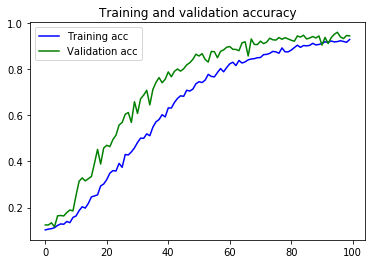

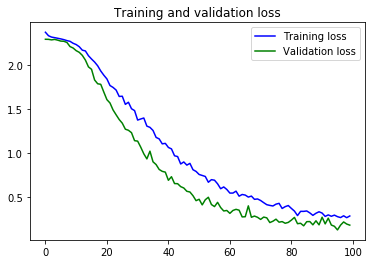

In [36]:
import matplotlib.pyplot as plt
acc = history_vgg16.history['acc']
val_acc = history_vgg16.history['val_acc']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [37]:
create_submission(model_vgg16,test_generator,'/home/jupyter/Submission/','submission_vgg16_100.csv')

3987/3987 [==============================] - 536s 134ms/step
536.1334865093231


# VGG19 Model

In [38]:
#Loading in Pretrained Model

from keras.applications import VGG19

vgg19_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

vgg19_base.trainable = True

set_trainable = False
for layer in vgg19_base.layers:
    if layer.name == 'block5_conv1' or layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
print(len(vgg19_base.trainable_weights))



16


In [40]:

model_vgg19,callbacks_vgg19= creade_model_2hidden(vgg19_base)
model_vgg19.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)                1290      
Total para

In [41]:
parallel_model_vgg19 = multi_gpu_model(model_vgg19, gpus=2)
parallel_model_vgg19.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [42]:
history_vgg19 = parallel_model_vgg19.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=100,
      callbacks=callbacks_vgg19,
      #use_multiprocessing = True,
      workers = 4,\
      shuffle = True,
      verbose=1)

print("Finished")

Epoch 1/100
100/100 [==============================] - 35s 354ms/step - loss: 2.5698 - acc: 0.0930 - val_loss: 2.3105 - val_acc: 0.1025
1e-05
Epoch 2/100
100/100 [==============================] - 29s 294ms/step - loss: 2.3489 - acc: 0.1170 - val_loss: 2.2846 - val_acc: 0.1444
1e-05
Epoch 3/100
100/100 [==============================] - 30s 297ms/step - loss: 2.3310 - acc: 0.1150 - val_loss: 2.2891 - val_acc: 0.1340
1e-05
Epoch 4/100
100/100 [==============================] - 30s 296ms/step - loss: 2.3130 - acc: 0.1135 - val_loss: 2.2881 - val_acc: 0.1307
1e-05
Epoch 5/100
100/100 [==============================] - 30s 297ms/step - loss: 2.3030 - acc: 0.1255 - val_loss: 2.2736 - val_acc: 0.1830
1e-05
Epoch 6/100
100/100 [==============================] - 30s 295ms/step - loss: 2.2931 - acc: 0.1305 - val_loss: 2.2654 - val_acc: 0.1540
1e-05
Epoch 7/100
100/100 [==============================] - 30s 296ms/step - loss: 2.2776 - acc: 0.1355 - val_loss: 2.2444 - val_acc: 0.1615
1e-05
Epoch 

In [43]:
model_json = model_vgg19.to_json()
with open("/home/jupyter/Saved_Models/VGG19_100.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_vgg19.save_weights("/home/jupyter/Saved_Models/VGG19_100.h5")
print("Saved model to disk")

Saved model to disk


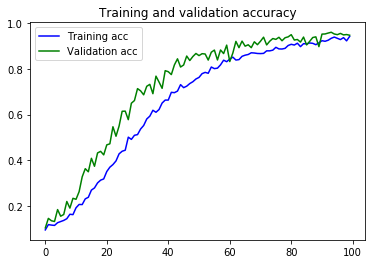

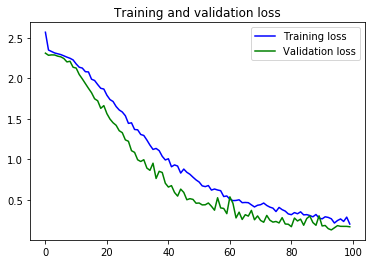

In [44]:
acc = history_vgg19.history['acc']
val_acc = history_vgg19.history['val_acc']
loss = history_vgg19.history['loss']
val_loss = history_vgg19.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()